# Machine Learning in Mineral Exploration - Understanding Classification Evaluation Metrics

### This notebook Iooks at different methods of evaluating ML model performance using mineral exploration data. It contains details on cross validating data using Scikit Learn's GroupShuffleSplit function to reduce the effects of spatial autocorrelation and how to construct a pipeline for ML model creation. The notebook then explains evaluation metrics such as Accuracy, Precision, Recall, the F1 score and the Receiver Operating Characteristic curve. 

<img src="Images/TITLE.png" />

To get started we'll import all the libraries needed in this notebook.

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import itertools
from scipy import stats
from scipy import interp

import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets
from matplotlib.patches import Patch

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## The Data

The study area for this notebook is the Gawler Craton in South Australia and our task is to use machine learning to predict areas of potential base metal mineralisation. The feature dataset we'll be using is a combination of geophysical and geological spatial data taken from SARIG and the Unearthed ExploreSA Gawler Challenge (definitely worth checking out for anyone keen on accessing high quality geological data and potentially earning some cash prizes). The target feature is 'Area of Interest' (AOI) and is defined as being 0 for a barren area or 1 for a mineralised area. Mineralisation in this case refers to areas of elevated base metals (Au, Cu, Pb, Zn and/or Ag) that are related to hydrothermal or magmatic intrusive sources (such as Olympic Dam or Carapateena). These locations have been chosen based upon a combination of existing mines/deposit locations and drillhole assays. 

<img src="Images/AOI.png" />

All features were preprocessed as raster images in QGIS and data was sampled at 500m x 500m pixel size. As the main focus of this notebook is to look at classification evaluation metrics, we won't go into feature preprocessing and selection steps for this dataset. For reference, all 15 features used in this example can be seen below.

<img src="Images/FEATURES.png" />

The raster images were converted into 1D numerical arrays and concatenated into a DataFrame, a process similarly seen in [this post](https://medium.com/@jackmaughan_50251/mineral-prediction-mapping-with-machine-learning-67a3846b3544). Next the data from the known areas of interest (both barren and mineralised) was extracted and stored into a csv file. Let's read it in and make some magic. 

In [2]:
#Reading in the DataFrame
df = pd.read_csv('/Users/jackmaughan/Desktop/Gawler_Features.csv')

In [3]:
df

,Areas_of_Interest,IP_100000m,IP_10000m,IP_150000m,IP_200000m,IP_20000m,IP_50000m,Log_Distance_To_Faults,Log_Distance_to_Archaean_Contact,Log_TMI_Merged_Slope,SA_GRAV,SA_GRAV_1VD,SA_TMI_RTP,SA_TMI_VRTP_1VD,SA_TMI_VRTP_PSDGRAV,TMI_Merged,Zones
0,1,2.820883,1.816062,2.987117,2.957402,1.764848,2.097355,8.562915,8.344032,1.923039,-4.934392,0.005453,453.28296,0.143676,-39.836740,1086.61840,2
1,0,2.804557,1.727324,2.977050,2.941502,1.602638,1.983393,8.834721,8.834721,1.128845,-5.194043,0.004025,498.98422,0.078441,-31.141480,617.73390,2
2,0,2.694229,1.689944,2.908677,2.768212,1.659999,2.079083,7.753500,10.151846,0.268313,-1.303209,-0.000570,-272.42166,-0.008299,-29.730923,266.01080,1
3,0,2.754284,1.686444,2.959255,2.892921,1.453064,1.571984,7.875227,8.661335,-0.235854,-5.091807,0.005596,101.18466,0.016376,-31.054740,568.47980,2
4,0,2.735122,1.748282,2.863593,2.700618,1.788256,2.230790,8.319839,9.452106,2.027054,-7.236649,0.002715,-166.96223,-0.189150,-35.360264,236.68782,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0,3.116837,1.988076,2.940882,2.862363,2.153999,3.174888,8.329572,8.381520,2.693192,-12.704970,0.000340,378.96430,0.153007,62.621030,468.72240,25
330,0,3.159340,2.689270,2.866878,2.767384,3.041932,3.536589,9.613204,7.745506,0.558646,-13.346372,0.001905,194.91040,0.019076,68.996994,211.59685,25
331,1,3.285728,4.652879,3.340603,3.319970,3.898999,3.571000,8.210844,7.003810,1.103104,-14.116680,0.000169,-260.99580,-0.081170,22.559025,-107.31129,24
332,0,3.604119,3.760238,3.513945,3.417534,4.020409,4.223606,7.805900,7.657473,2.708588,-22.919182,-0.000111,-149.89143,-0.198861,21.142788,306.70895,24


Here we can see our target variable 'Areas of Interest', our 15 features and another feature called 'Zones'. Under the assumption that all exploratory data analysis and preprocessing of data has been completed, let's move straight into how we will cross validate the train/test sets.

## Spatial Cross Validation

In my previous notebook on [Machine Learning Regression on Exploration Soil Sampling Grids](https://medium.com/@jackmaughan_50251/machine-learning-regression-on-exploration-soil-sampling-grids-25d2e4b0565d) we looked at splitting training and testing data from separately spaced zones to overcome the effects of spatial autocorrelation, which causes overfitting in our models. In this notebook we'll look at doing something similar using Scikit-Learn's Group Shuffle Split (GSS). As the name suggests, this tool splits the dataset based upon a defined group variable. When creating the feature dataset I created a group feature named 'Zones'. The zones are pictured below.

<img src="Images/Zones.png" />

The zone extents are derived from the 200k geology maps of South Australia found on the SARIG website and have been numbered with respect to the study region. Each area of known interest has been assigned the zone number for which it is located and will be split based upon that zone using GSS.

In [4]:
#Sorting data by Zones
df = df.sort_values('Zones')

#Splitting the features
X = df.drop(['Areas_of_Interest', 'Zones'], axis=1)

#Splitting the target feature
Y = df['Areas_of_Interest']

#Splitting the zones
Z = df['Zones']

An issue with splitting our train and test in this fashion is that each zone has a varying amount of samples, some even have none. This makes it impossible to keep a consistent train-test sample ratio across the cross validations (CV) sets. To visualise how many data points are in each zone we can plot a histogram of the zones.

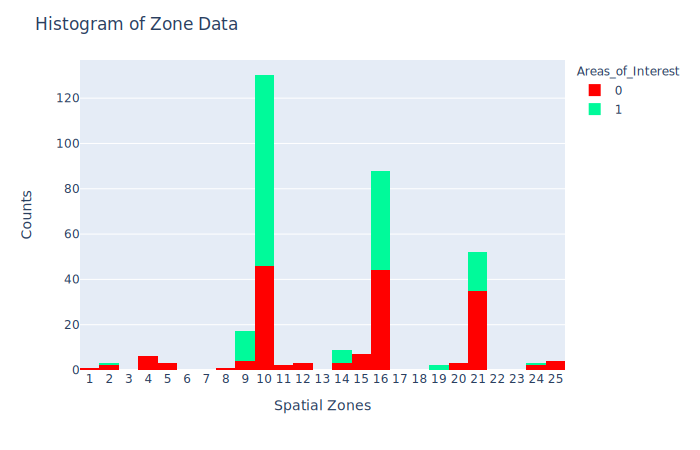

In [5]:
#Setting histogram
fig = px.histogram(df, x="Zones", color="Areas_of_Interest", hover_data=df.columns,
                   color_discrete_sequence=['red', 'mediumspringgreen'])

#Updating layout 
fig.update_layout(xaxis = dict(title='Spatial Zones', tickmode = 'linear', tick0 = 1, dtick = 1), 
                  yaxis = dict(title='Counts'),
                  title = "Histogram of Zone Data",
                  barmode='stack')

fig.show('svg')

As we can see, some zones have a significantly higher amount of data points within them, some have only barren data points or mineralised data points and others have no data at all. In the next step we will use GSS to split our data into 6 different cross validation sets, and attempt to keep our train - test ratio as close to 70% - 30% as possible.

In [6]:
#Splitting our data by zone for cross validation
gss = GroupShuffleSplit(n_splits=6, train_size=0.7, random_state=4)

Next we'll create a figure that shows how each of those 6 CV sets split the data in accordance to the zones. This can show us approximately how many data points are going into each of the train/test sets.

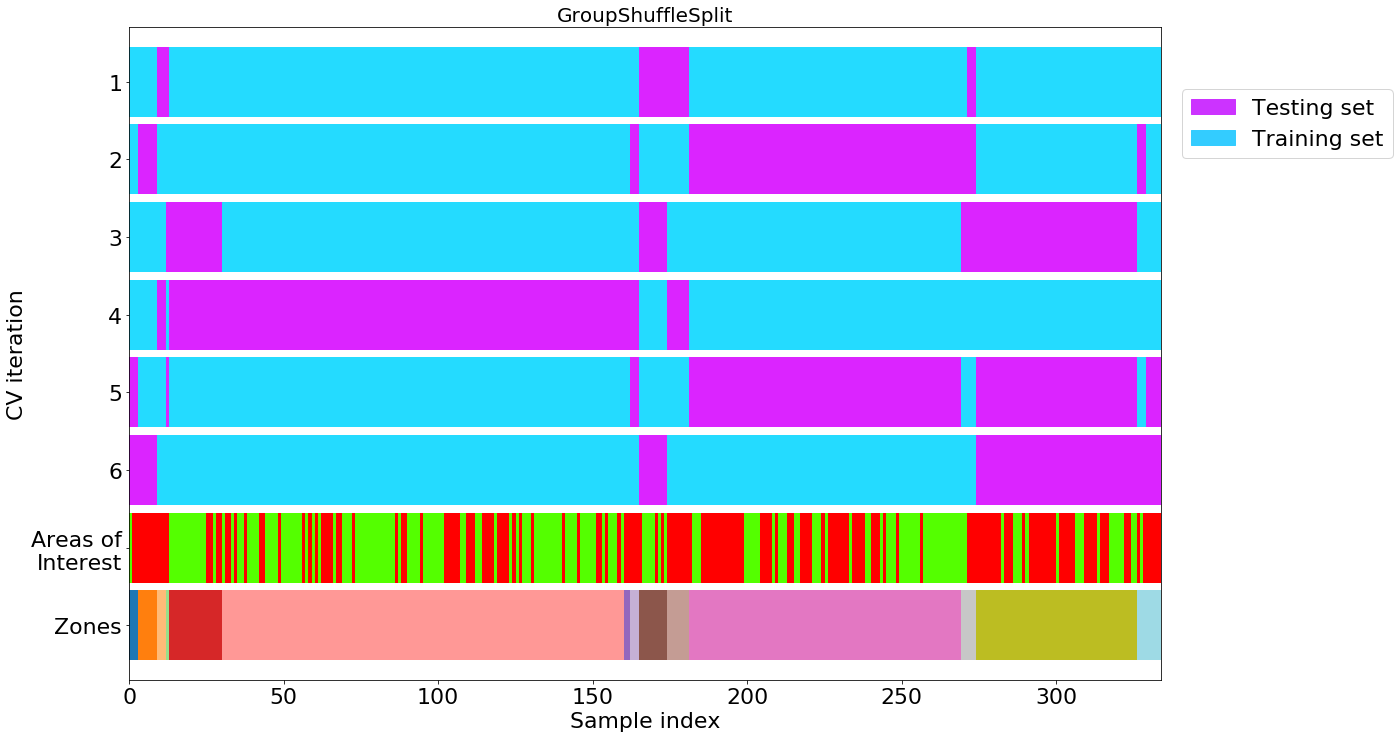

In [7]:
#Updating figure settings
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots()

# Generate the training/testing visualizations for each CV split
for i, (train, test) in enumerate(gss.split(X=X, y=Y, groups=Z)):
    
    # Fill in indices with the training/test groups
    indices = np.array([np.nan] * len(X))
    indices[test] = 1
    indices[train] = 0

    # Visualize the results
    ax.scatter(range(len(indices)), [i + .5] * len(indices),
                   c=indices, marker='_', lw=70, cmap='cool',
                   vmin=-.2, vmax=1.2)

# Plot the data classes and groups at the end
ax.scatter(range(len(X)), [i + 1.5] * len(X),
               c=Y, marker='_', lw=70, cmap='prism')
ax.scatter(range(len(X)), [i + 2.5] * len(X),
               c=Z, marker='_', lw=70, cmap='tab20')

#Update formatting
n_splits=6
yticklabels = list(range(1, n_splits+1)) + ['Areas of\nInterest', 'Zones']
ax.set(yticks=np.arange(n_splits+2) + 0.5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(Y)])
ax.set_title('{}'.format(type(gss).__name__), fontsize=20)
ax.legend([Patch(color=plt.cm.cool(.8)), Patch(color=plt.cm.cool(.2))],
          ['Testing set', 'Training set'], loc=(1.02, .8))
fig.set_size_inches(18.5, 12)


In other cross validation settings it would make sense to take the average of each CV metric and use that to define model robustness. As we are dealing with spatially different train/test sets with large variation in data size it's important to look further into how each CV set performs independently. We can see what zones were assigned to be either train or test data in the following cell. 

In [8]:
#Looping over each CV set to see what zones are included in the train/test data
for i, (train, test) in enumerate(gss.split(X, Y, Z)):
    print ('CV: '+str(i+1)+' is training zones '+str(Z.iloc[train].unique())+
           ' and testing on zones '+str(Z.iloc[test].unique()))

CV: 1 is training zones [ 2  4  9 10 11 12 16 19 21 24 25] and testing on zones [ 1  5  8 14 15 20]
CV: 2 is training zones [ 1  2  5  8  9 10 11 14 15 21 25] and testing on zones [ 4 12 16 19 20 24]
CV: 3 is training zones [ 1  2  4  5 10 11 12 15 16 24 25] and testing on zones [ 8  9 14 19 20 21]
CV: 4 is training zones [ 1  2  4  8 14 16 19 20 21 24 25] and testing on zones [ 5  9 10 11 12 15]
CV: 5 is training zones [ 1  4  5  9 10 11 14 15 19 20 24] and testing on zones [ 2  8 12 16 21 25]
CV: 6 is training zones [ 1  5  8  9 10 11 12 15 16 19 20] and testing on zones [ 2  4 14 21 24 25]


Now that we have the data ready we can look at constructing a pipeline.

## Pipeline

A pipeline is a tool that creates a single object from multiple processing steps. Each individual step in a pipeline is applied to the data in the specific order that it was set. We'll construct a simple pipeline in this example, which applies a scalar to the data and then fits a machine learning model to it (more examples on pipelines can be found [here](http://queirozf.com/entries/scikit-learn-pipeline-examples)). Let's set up our pipeline with Scikit-Learns Min Max Scalar and Support Vector Machine Classifier.

In [9]:
#Setting scalar
scalar = MinMaxScaler()

#Setting machine learning model
model = SVC(C=10, gamma=1, kernel='rbf', probability=True)

In [10]:
#Constructing a pipeline
pipeline = Pipeline([('transformer', scalar), ('estimator', model)])

Our pipeline is now set and ready to be fitted to some data.

<img src="Images/pipes.png" />

Besides making workflows easily reproducible and consistent, using a pipeline also reduces data leakage between training and test sets. This is because the pipeline fits the scalar to the data in the training set first and then transforms the testing set data. If we scaled the entire feature set before splitting into train and test sets, the training data would be exposed to information contained in the test set (like altered statistical data such as the mean and standard deviation). More on data leakage can be found [here](https://machinelearningmastery.com/data-leakage-machine-learning/). Let's evaluate some models.

## Evaluation Metrics

When we create a machine learning classification model we want to know how well the it performs, aka how well it predicts classes correctly. In our case we want to know how well our support vector machine classifier predicts barren and mineralised areas given the data we've provided. Here we will look at some of the most common ways to evaluate model performance.

### Accuracy

Accuracy (or Classification Accuracy) is the go to metric for testing how well a model performs. We can calculate the accuracy like this;

In [11]:
#Looping over each CV split
for i, (train, test) in enumerate(gss.split(X, Y, Z)):
    
    #Fitting the model to the training data
    pipeline.fit(X.iloc[train].values, Y.iloc[train].values)
    
    #Using this model to predict on the test data
    Y_pred = pipeline.predict(X.iloc[test].values)
    
    #Accessing and printing the accuracy of each train/test set
    acc = accuracy_score(Y.iloc[test], Y_pred)
    print('Accuracy CV '+str(i+1)+': '+"%.1f"% (acc*100)+'%')

Accuracy CV 1: 70.8%
Accuracy CV 2: 72.4%
Accuracy CV 3: 53.6%
Accuracy CV 4: 48.1%
Accuracy CV 5: 70.9%
Accuracy CV 6: 53.2%


The results show that there is quite a variance in the accuracy over our different CV splits. This could be due to things like spatial differences in the data or the varying train/test split size, but for the sake of this notebook we won't worry about it. 

However, we do want to investigate what accuracy represents and how it is calculated. Accuracy is the number of correctly classified data points divided by the total number data points. To visualise this better let's have a look at the Confusion Matrix.

<img src="Images/Hulk.jpg" />

### Confusion Matrix

A confusion matrix is a way of visualising how well a model predicts each class for the test data set. In our case we running a binary classification (to classify whether an area is barren or mineralised) so we have a 2x2 confusion matrix that looks like this. 

<img src="Images/confmat2.png" />

Ideally we want our model to have as many data points fall into the True Negative or True Positive cells, indicating that the model successfully predicted each point. Here is the equation for accuracy for this confusion matrix.

<img src="Images/Accuracy.png" />

Where;
 - __TN__ is a barren area classified as a barren area
 - __FP__ is a barren area classified as a mineralised area
 - __FN__ is a mineralised area classified as a barren area
 - __FP__ is a mineralised area classified as a mineralised area

With this in mind let's plot the confusion matrix for each cross validation set. (Note: cell output has been manually edited for visualisation purposes)

In [ ]:
plt.rcParams.update({'font.size': 24})

#Loop over the CV splits
for i, (train, test) in enumerate(gss.split(X, Y, Z)):
        
        #Fitting the pipeline to training data
        pipeline.fit(X.iloc[train].values, Y.iloc[train].values)
        
        #Predicting the test set
        Y_pred = pipeline.predict(X.iloc[test].values)
        
        #Setting and plotting a confusion matrix
        conf_mat = confusion_matrix(Y.iloc[test].values, Y_pred)
        fig, ax = plot_confusion_matrix(conf_mat,
                                show_absolute=True,
                                colorbar=True,
                                cmap='Greens',
                                figsize=(12,12))
        ax.set_title('SVM cv: '+str(i+1))
        plt.show()

<img src="Images/confmatpng.png" />

When we calculated accuracy for each set, the cross validation number 1 returned a decent accuracy with 70.8%, but now looking at the confusion matrix it doesn't seem to be the best fit. It shows that out of the barren areas 16 out of 18 were correctly classified (nice), but only 1 out of 6 mineralised areas were classified correctly (not nice). The correctly classified barren areas hugely impact the accuracy of the model making it appear robust but in reality the models performance is quite poor. 

As a metric, accuracy is most effective when each class has close to the same number of data points and can become unreliable when there is a big difference in class data (as we just saw in cv:1). To understand the performance of our model given this situation we can look at using different evaluation metrics such as precision and recall.

### Precision

Precision is another way we can evaluate our models robustness by using the following formula.

<img src="Images/Precision.png" />

In our example, this tells us the amount of correctly classified mineralised areas over the amount of both correctly and incorrectly classified mineralised areas. Precision is very important as we want to keep the amount of incorrectly classified (False Positive) data points to a minimum (ie we don't want to classify barren areas as mineralised). It can be calculated in python similarly to accuracy as seen in the next cell.

In [12]:
#Looping over each CV split
for i, (train, test) in enumerate(gss.split(X, Y, Z)):
    
    #Fitting the model to the training data
    pipeline.fit(X.iloc[train].values, Y.iloc[train].values)
    
    #Using this model to predict on the test data
    Y_pred = pipeline.predict(X.iloc[test].values)
    
    #Accessing and printing the precision of each train/test set
    pre = precision_score(Y.iloc[test], Y_pred)
    print('Precision CV '+str(i+1)+': '+"%.1f"%(pre*100)+'%')

Precision CV 1: 33.3%
Precision CV 2: 65.0%
Precision CV 3: 46.7%
Precision CV 4: 93.3%
Precision CV 5: 66.7%
Precision CV 6: 38.3%


Here we can see that even though CV:1 had a reasonably high accuracy it now has the lowest precision. An important thing to keep in mind.

### Recall (Sensitivity)

Another metric to consider is the recall or sensitivity of the model. This can be calculated as follows. 

<img src="Images/Recall.png" />

Recall tells us the amount of correctly classified mineralised areas over the amount of actual mineralised areas. Recall is important but not as crucial as precision in our case as we would rather mineralised areas be classified as barren than barren areas be classified as mineralised. To get the recall for each cross validation we can use the code in the next cell.

In [13]:
#Looping over each CV split
for i, (train, test) in enumerate(gss.split(X, Y, Z)):
    
    #Fitting the model to the training data
    pipeline.fit(X.iloc[train].values, Y.iloc[train].values)
    
    #Using this model to predict on the test data
    Y_pred = pipeline.predict(X.iloc[test].values)
    
    #Accessing and printing the recall of each train/test set
    rec = recall_score(Y.iloc[test], Y_pred)
    print('Recall CV '+str(i+1)+': '+"%.1f"%(rec*100)+'%')

Recall CV 1: 16.7%
Recall CV 2: 83.0%
Recall CV 3: 18.4%
Recall CV 4: 14.4%
Recall CV 5: 58.1%
Recall CV 6: 72.0%


### F1 Score

With Precision and Recall both being important evaluation metrics it'd be nice to have a single value that represents both these values. That's where the F1 score comes in. This metric is the harmonic mean of both the recall and precision values and can be calculated like this:

<img src="Images/F1.png" />

The F1 score is the harmonic mean of Precision and Recall instead of the arithmetic mean because if one of the values is really small it is reflected in the F1 score. We can get the F1 Score for each CV in python as seen in the following cell.

In [14]:
#Looping over each CV split
for i, (train, test) in enumerate(gss.split(X, Y, Z)):
    
    #Fitting the model to the training data
    pipeline.fit(X.iloc[train].values, Y.iloc[train].values)
    
    #Using this model to predict on the test data
    Y_pred = pipeline.predict(X.iloc[test].values)
    
    #Accessing and printing the precision of each train/test set
    F1 = f1_score(Y.iloc[test], Y_pred)
    print('F1 Score CV '+str(i+1)+': '+"%.1f"%(F1*100)+'%')

F1 Score CV 1: 22.2%
F1 Score CV 2: 72.9%
F1 Score CV 3: 26.4%
F1 Score CV 4: 25.0%
F1 Score CV 5: 62.1%
F1 Score CV 6: 50.0%


### Specificity

Specificity is closely related to Recall and tells us the exact same information, but for the negative class (aka barren areas). It can be calculated like this.

<img src="Images/Specificity.png" />

Specificity is used when plot the Receiver Operating Characteristics Curve. We will touch on shortly, but first let's see how to view all these metrics in a report. 

### Classification Report

The classification report provides us with the above evaluation metrics for our model. Let's take the first cross validation train/test split and retrieve the classification report for that split using sklearn.

In [15]:
#Selecting the first cross validation set
cv1 = next(itertools.islice(gss.split(X, Y, Z), 0, None))
train, test = enumerate(cv1)
train = train[1]
test = test[1]

In [16]:
#Fitting the pipeline to the 
pipeline.fit(X.iloc[train].values, Y.iloc[train].values)
    
#Predicting the test data
Y_pred = pipeline.predict(X.iloc[test].values)
    
#Accessing and printing the accuracy of each train/test set
cr = classification_report(Y.iloc[test], Y_pred)
print('SVM CV: 1 - Classification Report')
print(cr)

SVM CV: 1 - Classification Report
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.33      0.17      0.22         6

    accuracy                           0.71        24
   macro avg       0.55      0.53      0.52        24
weighted avg       0.65      0.71      0.67        24



Here we can see the precision, recall and F1 score for both the barren and mineralised areas (0 and 1), the accuracy for the model and how many data points are in each class (support). In this CV the overall accuracy is 71% as we saw earlier, but the other evaluation metrics show that this model did a poor job of classifying mineralised areas, with low precision, recall and F1 scores. This is a great example of why it's important to look past the accuracy metric and assess other means of evaluation.  

## Receiver Operator Characteristics & Area Under the Curve

Another very common way of evaluating models is by looking at the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) value. The ROC curve is a way of visualising the relationship between the recall (sensitivity) and the specificity of a model, but before going too far I think it's important to understand prediction probabilities first. 

When a machine learning model is predicting what class each sample belongs to it creates a 'prediction probability' for that sample. The following plot is a way of visualising the prediction probability of a sample being classed as positive (or mineralised in our case).

<img src="Images/probplot.png" />

The dotted line at the 50% probability mark represents a classification threshold. The model classifies any data point above the classification threshold as mineralised and anything below it as barren. The green and red colours represent the actual classes of the test set, where green is mineralised and red is barren. As you can see there are misclassified values above and below the classification threshold, which are the False Negative and the False Positive data points we see in confusion matrices. 50% is the default classification threshold for prediction probability and is what has been used when we have plotted our confusion matrices so far in this example.

Going back to the ROC curve and AUC value, and adding to the confusion, we'll introduce two new variable names; the True Positive Rate and the False Positive Rate. These are defined as;

- __True Positive Rate (TPR)__ = Recall
- __False Positive Rate (FPR)__ = (1 - Specificity)

In an ROC plot these two values represent the X and Y axis. Here is a figure of what an ROC curve would look like for a generic model:

<img src="Images/ROCAUC.png" />

To put it simply, the curve represents the relationship between TPR and FPR and the larger the area under the curve the better the model, but how do we plot the curve? If we only get one confusion matrix for each train/test set then we would only be able place one point on an ROC plot. To get the curve we need to consider the classification threshold from the probability plot previously mentioned. We stated that our default classification threshold was 50%, but imagine now that we move that threshold. We would A) get a different confusion matrix, and therefore B) different True Positive and False Positive Rates. This is better illustrated in the figure below, where 7 classification thresholds have been plotted on a probability plot, with example data containing 100 negative data points (barren) and 100 positive data points (mineralised).

<img src="Images/prob example.png" />

From each of the 7 classification thresholds a confusion matrix can be plotted and the TPR and FPR values calculated, keeping in mind that anything above the threshold is classified as positive and anything below the threshold is classified as negative. The TPR and FPR values can then be plotted on the ROC graph and a curve can be fitted to these points. The way I like to picture it is to imagine that the classification threshold is a bus windscreen wiper, moving across the probability plot from right to left, calculating and plotting the TPR and FPR on the ROC plot as it moves along.

<img src="Images/otto.png" />

Ideally we want to reduce the amount of incorrectly classified data points (False Positive and False Negative values) and in turn keep the curve as close to TPR=1 and FPR=0 as possible until all True Positive samples have been classified. We can then look at the area under the curve and use that as our single value evaluation metric for the model. Varying models and their respective ROC curves can be seen below, where the perfect model returns an AUC of 1.00.

<img src="Images/ROCAUC2.png" />

Now we know how the ROC curve is plotted lets do it in python with our Gawler dataset. For a start we'll only look at the second cross validation set (CV: 2) and start by plotting the classification probability plot.

In [17]:
#Selecting the first cross validation set
cv2 = next(itertools.islice(gss.split(X, Y, Z), 1, None))
train, test = enumerate(cv2)
train = train[1]
test = test[1]

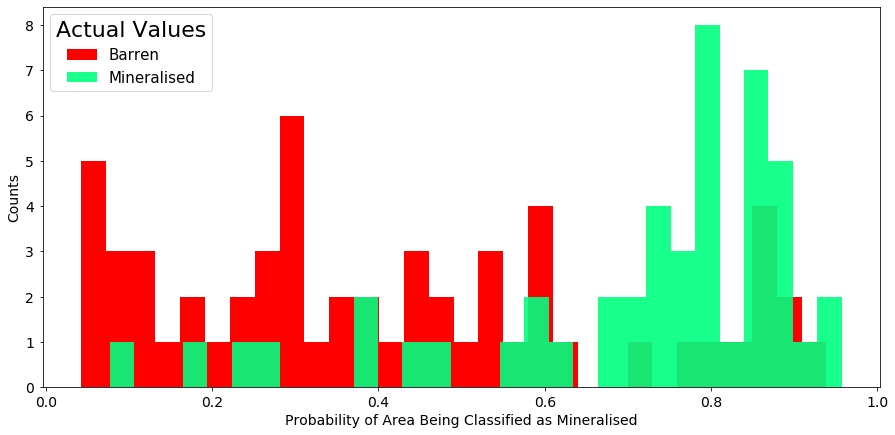

In [18]:
#Fitting the pipeline on the training data and predicting the test
pipeline.fit(X.iloc[train], Y.iloc[train])
prediction=pipeline.predict_proba(X.iloc[test])[:,1]

#Plotting the probability plot
plt.figure(figsize=(15,7))
plt.hist(prediction[Y.iloc[test]==0], bins=30, label='Barren', color='r')
plt.hist(prediction[Y.iloc[test]==1], bins=30, label='Mineralised', alpha=0.9, color='springgreen')
plt.xlabel('Probability of Area Being Classified as Mineralised', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.legend(title='Actual Values', fontsize=15)
plt.tick_params(axis='both', labelsize=14, pad=5)
plt.show() 

Here we can see how our SVM model assigned mineralised prediction probabilities for the CV:2 test set, where the samples are coloured by their actual values. We can see straight away that the majority of mineralised samples were assigned high prediction probabilities, which is a good sign, but there are still some negative samples grouped amongst them. Let's look at the ROC curve for these samples and the associated AUC value.

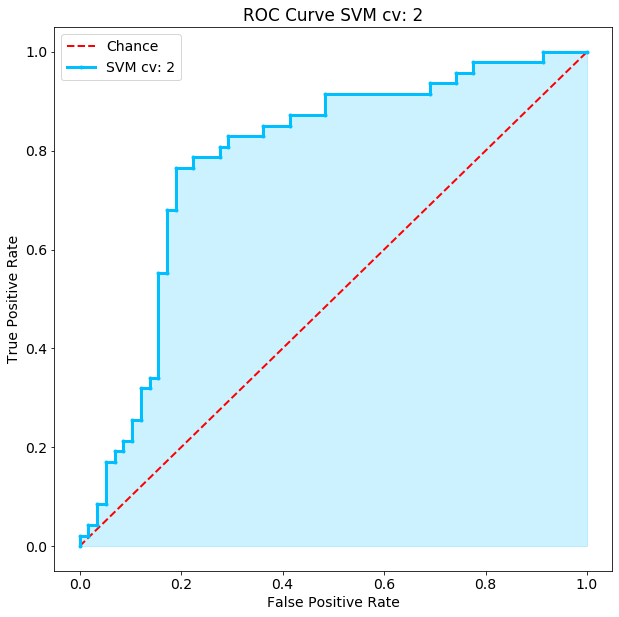

Area Under the Curve : 78.4%


In [19]:
#Getting the FPR, TPR and thresholds from the test data
fpr, tpr, thresholds = roc_curve(Y.iloc[test], prediction)

#Update some figure settings
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,10))

#Plot the roc curve
plt.plot([0,1], [0,1], linestyle='--', label='Chance', c='r', lw=2)
plt.plot(fpr, tpr, marker='.', label='SVM cv: 2', c='deepskyblue', lw='3')
plt.fill_between(fpr, tpr, color='deepskyblue', alpha=0.2)

#Updating labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM cv: 2')
plt.legend()
# show the plot
plt.show()

AUC = auc(fpr,tpr)
print('Area Under the Curve : '+"%.1f"%(AUC*100)+'%')

An AUC value of 78.4% is pretty good and the shape of the curve looks nice, but in this plot the curve is stepped. This is because the amount of data in the test set is quite small, and each step in the curve is representative of the classification threshold. This makes no difference in how we calculate the AUC and just means we don't have enough data to get the 'smooth' ROC curve we saw in the earlier example. Now let's have a look at the ROC curve for all of the cross validations and compare them. 

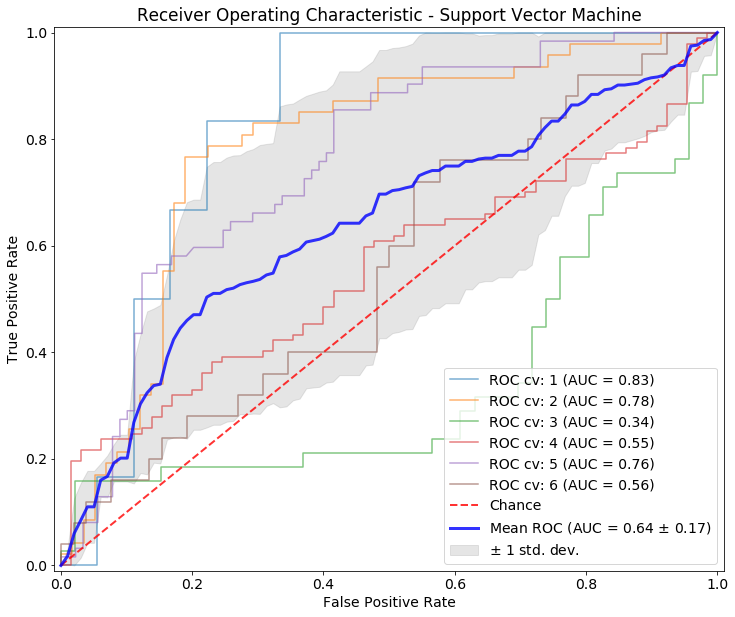

In [20]:
#Setting the chance line and empty lists
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

#Updating figure settings
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12,10))

#Fitting our model and plotting each cv set
for i, (train, test) in enumerate(gss.split(X, Y, Z)):
    
    pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
    pipeline.fit(X.iloc[train], Y.iloc[train])
    viz = plot_roc_curve(pipeline, X.iloc[test], Y.iloc[test],
                         name='ROC cv: {}'.format(i+1),
                         alpha=0.6, lw=1.5, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

#Plotting the chance line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

#Plotting the mean and std of all cv
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=3, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

#Updating figure settings
ax.set(xlim=[-0.01, 1.01], ylim=[-0.01, 1.01],
       title="Receiver Operating Characteristic - Support Vector Machine")
ax.legend(loc="lower right")
plt.show()

Again, we can see quite a large variance of how the SVM model performs over our different cross validation sets. In particular, CV: 3 is classifying horrifically, with CV:4 and CV:6 not far behind. Here would be a good opportunity to assess which zone data was incorporated into those cross validation sets and determine why they are performing so badly in comparison to the others. Given that we are happy with evaluation metrics from this SVM classifier, we could go on to fit the model to our unknown data and see how it predicts the unknown areas for mineralisation in the Gawler Craton, but we'll leave that for another day.

## Conclusion

In this notebook we've looked at how to spatially cross validate train/test datasets, how to construct a pipeline of steps for reproducible data scaling and fitting and looked at the most common ways of evaluating classification models. From this notebook I hope you keep these things in mind;

- Using Group Shuffle Split is a good way to reduce the effects of spatial autocorrelation through grouped cross validation

- Pipeline is a very useful tool for preventing data leakage

- Accuracy is only useful when you're predicting classes with the same amount of data points (or close to)

- It's important to look past the model accuracy and explore other evaluation metrics before deciding on a model

## Helpful Links

[Evaluating a Classification Model](https://www.ritchieng.com/machine-learning-evaluate-classification-model/)

[Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

[Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)

[Metrics to Evaluate your Machine Learning Algorithm](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234)

[Beginners Guide to Understanding ROC Curve](https://analyticsindiamag.com/beginners-guide-to-understanding-roc-curve-how-to-find-the-perfect-probability-threshold/)

[Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)